In [2]:
import os
import gc
import ot
import pickle
import anndata
import scanpy as sc
import pandas as pd
import numpy as np
from scipy import sparse
from scipy.stats import spearmanr, pearsonr
from scipy.spatial import distance_matrix
import matplotlib.pyplot as plt

import commot as ct

## **Load and preprocess data**

In [3]:
sp_datadir = './data/original_data'

In [4]:
X = sparse.load_npz(sp_datadir+'/expression.npz')
genes = list( np.loadtxt(sp_datadir+'/genes.txt', dtype=str) )
pts = np.loadtxt( sp_datadir+'/positions.csv' )
adata_sp = anndata.AnnData(X=X, var=pd.DataFrame(index=genes))
adata_sp.obsm['spatial'] = pts

In [4]:
sc.pp.normalize_total(adata_sp, inplace=True)
sc.pp.log1p(adata_sp)

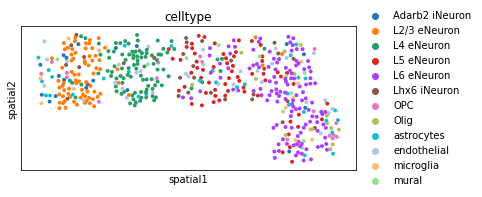

In [5]:
# Cell type annotation from Giotto
df_celltype = pd.read_csv('./data/celltype_annotation.csv', index_col=0)
celltypes = list(df_celltype.values.reshape(-1))
adata_sp.obs['celltype'] = pd.Series(list(celltypes), dtype="category").values
sc.pl.spatial(adata_sp, color='celltype', spot_size=100)

In [6]:
# save for R
adata_r = anndata.AnnData(X=X, var=pd.DataFrame(index=genes))
adata_r.obsm['spatial'] = pts
adata_r.obs['celltype'] = pd.Series(list(celltypes), dtype="category").values
adata_r.write("./data/adata_r.h5ad")

In [7]:
adata_r.X.max()

138.0

## **Cell-cell communication network**

In [5]:
df_cellchat = ct.pp.ligand_receptor_database(species='mouse')
print(df_cellchat.shape)
df_cellchat_filtered = ct.pp.filter_lr_database(df_cellchat, adata_sp, min_cell_pct=0.0)
print(df_cellchat_filtered.shape)

(1209, 4)
(598, 4)


In [13]:
ct.tl.spatial_communication(adata_sp,
    database_name='cellchat', df_ligrec=df_cellchat_filtered, dis_thr=500, heteromeric=True, pathway_sum=True)

In [15]:
adata_sp.write("./data/adata.h5ad")

In [6]:
X = sparse.load_npz(sp_datadir+'/expression.npz')
genes = list( np.loadtxt(sp_datadir+'/genes.txt', dtype=str) )
pts = np.loadtxt( sp_datadir+'/positions.csv' )
adata_sp = anndata.AnnData(X=X, var=pd.DataFrame(index=genes))
adata_sp.obsm['spatial'] = pts
sc.pp.log1p(adata_sp)

In [7]:
adata_dis500 = adata_sp.copy()
ct.tl.spatial_communication(adata_dis500,
    database_name='cellchat', df_ligrec=df_cellchat_filtered, dis_thr=500, heteromeric=True, pathway_sum=True)

In [8]:
adata_dis500.write("./data/adata_dis500.h5ad")

In [9]:
adata_dis1000 = adata_sp.copy()
ct.tl.spatial_communication(adata_dis1000,
    database_name='cellchat', df_ligrec=df_cellchat_filtered, dis_thr=1000, heteromeric=True, pathway_sum=True)

In [10]:
adata_dis1000.write("./data/adata_dis1000.h5ad")

## **Communication directions**

In [12]:
adata = sc.read_h5ad("./data/adata.h5ad")

In [13]:
# rank the pathways by activity
def rank_signaling_activity(
    adata,
    database_name = None
):
    df_ligrec = adata.uns['commot-%s-info' % database_name]['df_ligrec']
    pathways = list(set(list(df_ligrec.iloc[:,2])))
    lr_pair_names = []
    for i in range(df_ligrec.shape[0]):
        lr_pair_names.append('%s-%s' % (df_ligrec.iloc[i,0], df_ligrec.iloc[i,1]))
    act_pathway = np.zeros([len(pathways)], float)
    act_lrpairs = np.zeros([len(lr_pair_names)], float)
    for i in range(len(act_pathway)):
        act_pathway[i] = np.sum(adata.obsm['commot-%s-sum-receiver' % database_name]['r-%s' % pathways[i]].values)
    for i in range(len(act_lrpairs)):
        act_lrpairs[i] = np.sum(adata.obsm['commot-%s-sum-receiver' % database_name]['r-%s' % lr_pair_names[i]].values)
    idx_pathway = np.argsort(-act_pathway)
    idx_lrpairs = np.argsort(-act_lrpairs)
    pathways = np.array(pathways, str)
    lr_pair_names = np.array(lr_pair_names, str)
    
    return pathways[idx_pathway], lr_pair_names[idx_lrpairs]

In [14]:
pathways, lr_pairs = rank_signaling_activity(adata, database_name='cellchat')

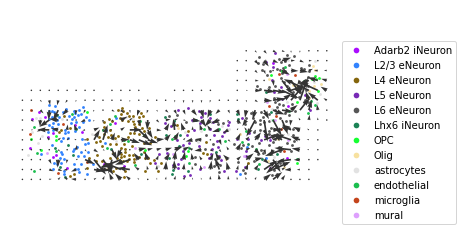

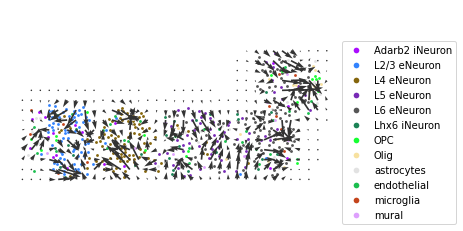

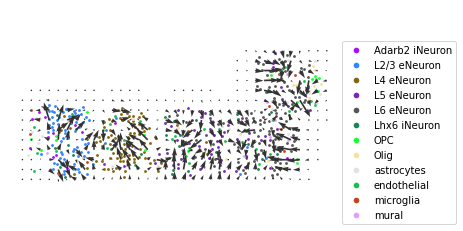

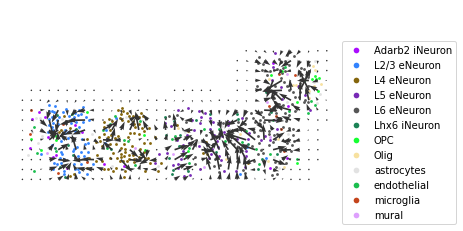

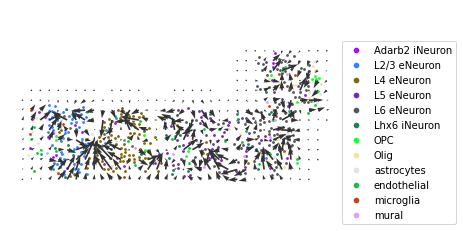

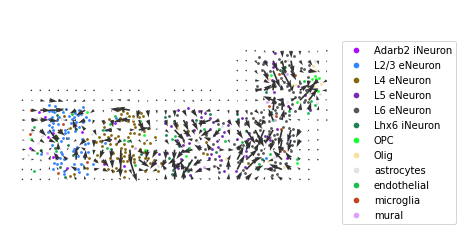

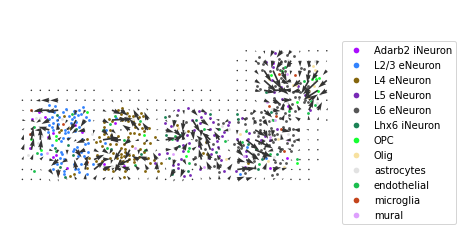

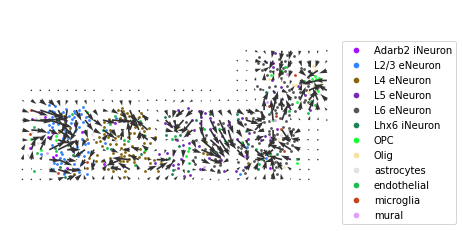

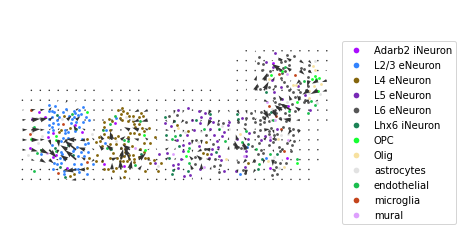

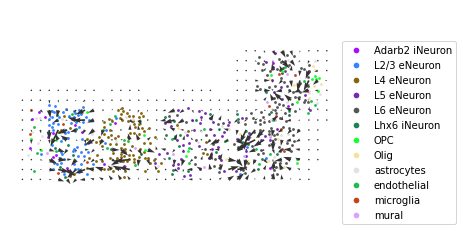

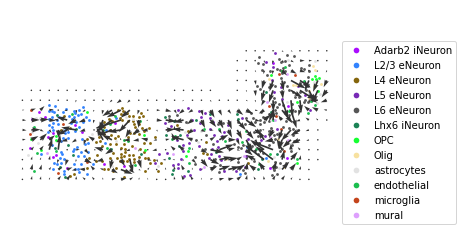

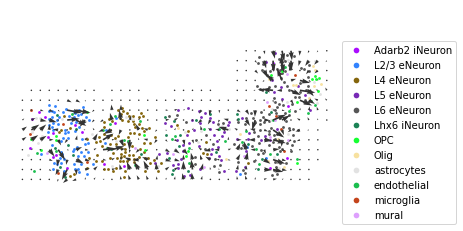

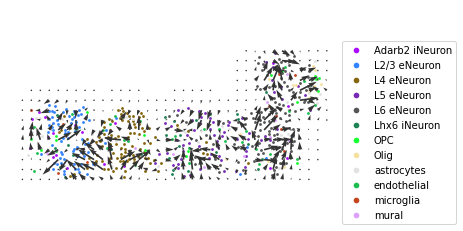

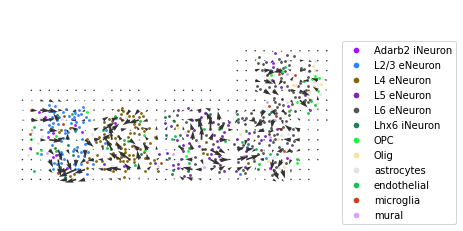

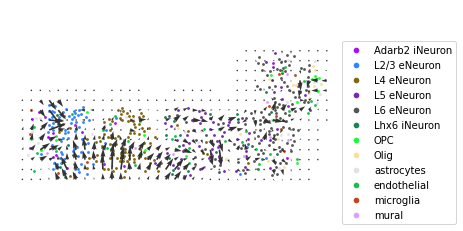

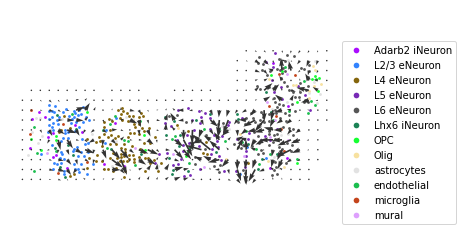

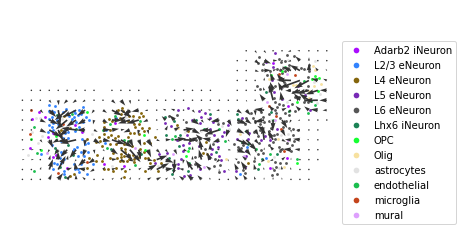

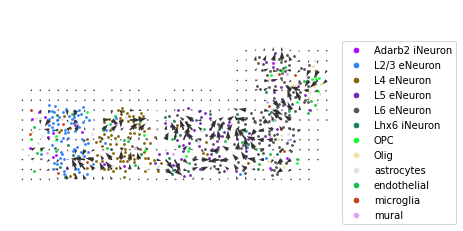

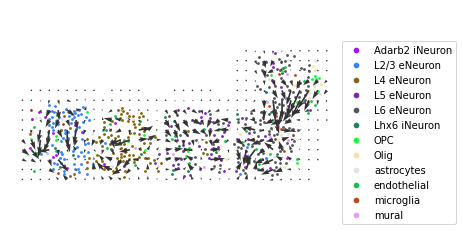

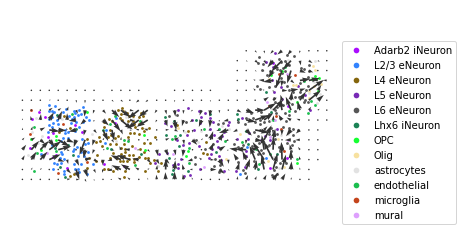

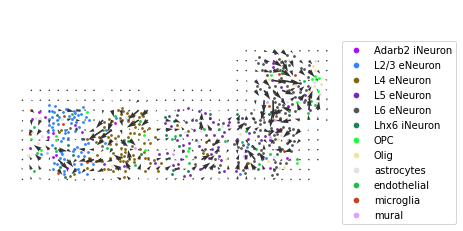

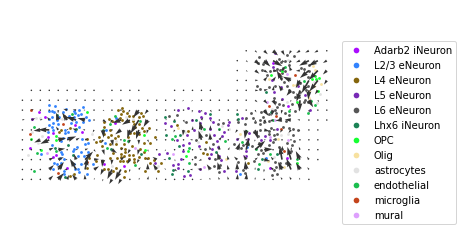

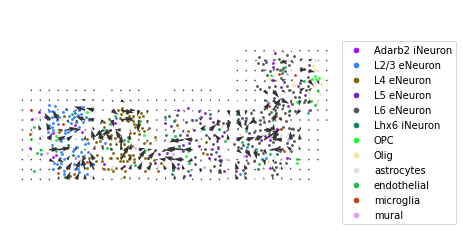

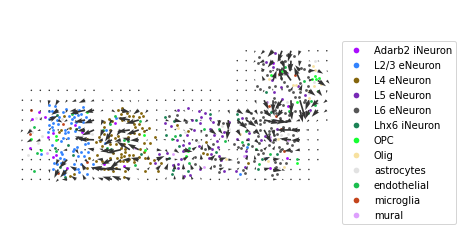

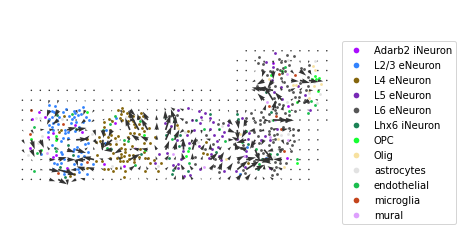

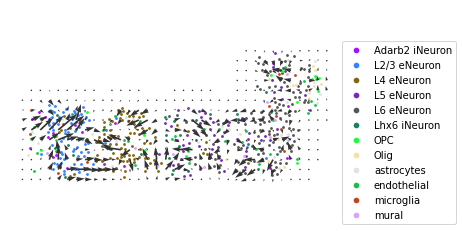

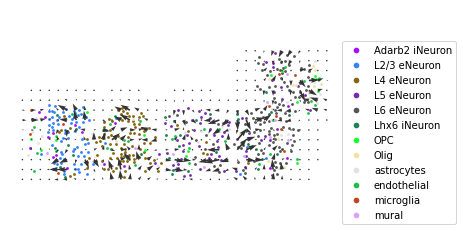

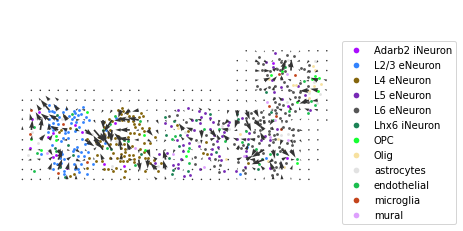

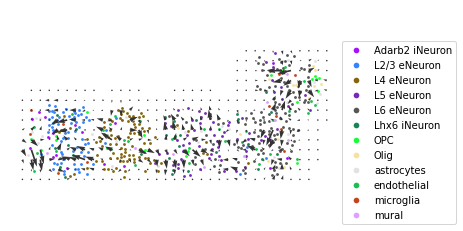

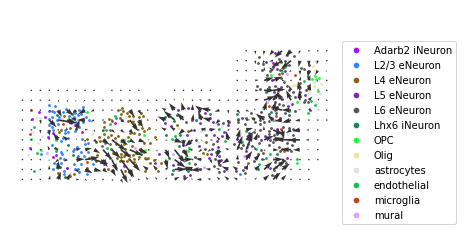

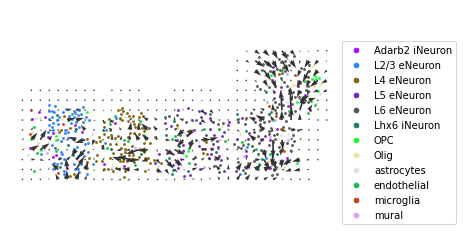

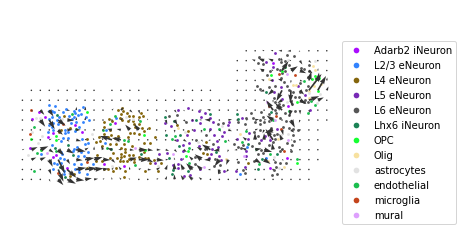

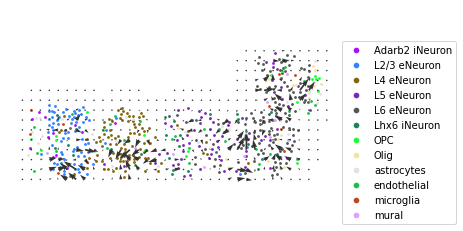

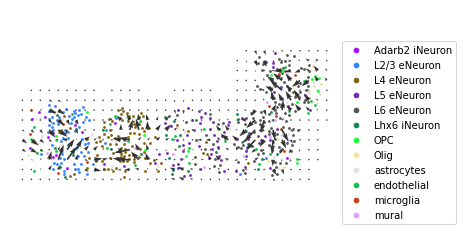

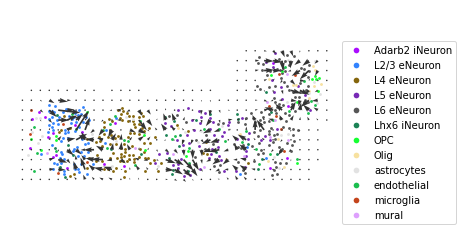

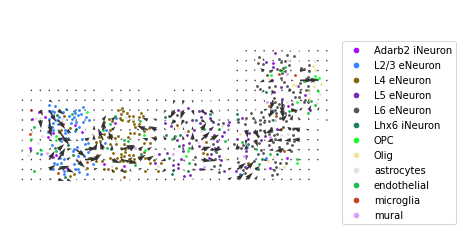

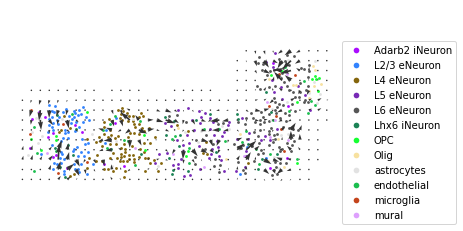

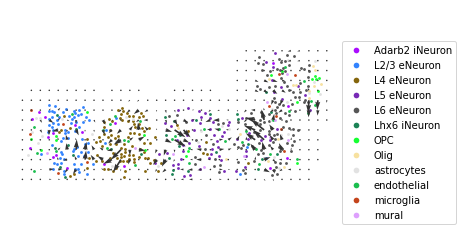

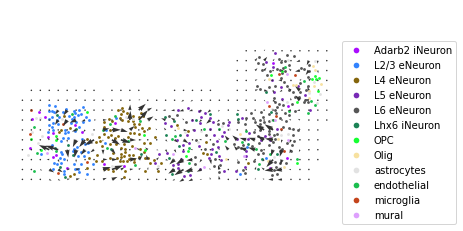

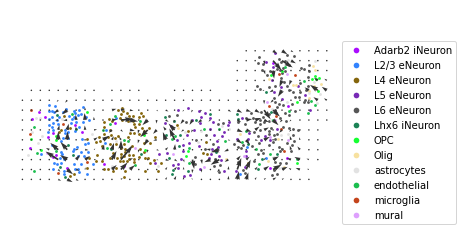

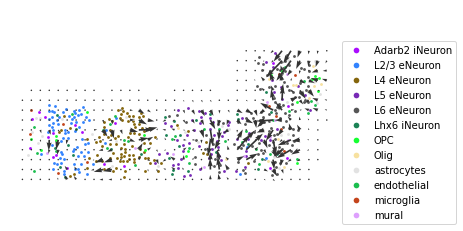

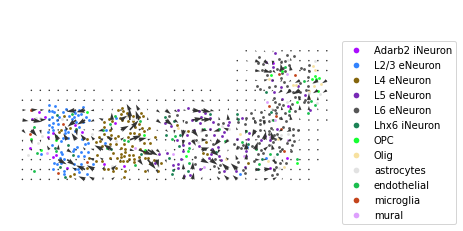

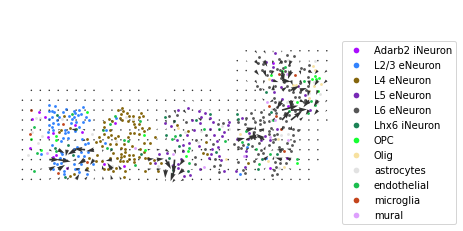

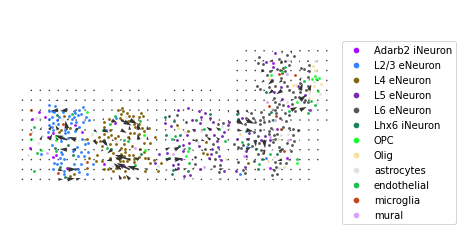

In [15]:
for pathway in pathways:
    ct.tl.communication_direction(adata, database_name='cellchat', pathway_name=pathway, k=20)
    ct.pl.plot_cell_communication(adata, database_name='cellchat', pathway_name=pathway, plot_method='grid', background_legend=True, 
        filename='./figure/ccc_dir/ccc_dir-%s.pdf' % pathway, 
        scale=0.0000075, ndsize=8, grid_density=0.7, summary='sender', background='cluster', clustering='celltype', cmap='Alphabet',
        normalize_v = True, normalize_v_quantile=0.995)

## **Cluster-cluster communication network**

In [16]:
ct.tl.cluster_position(adata, clustering='celltype')

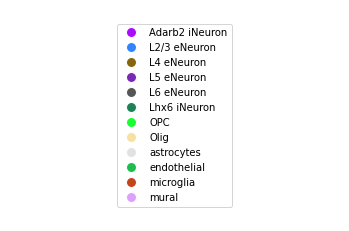

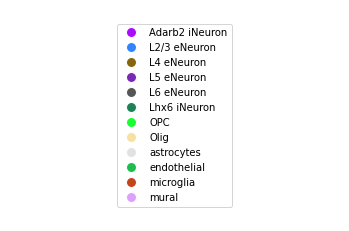

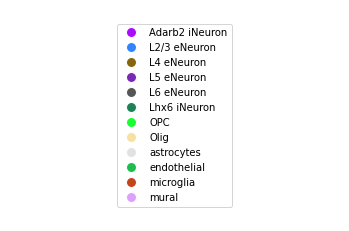

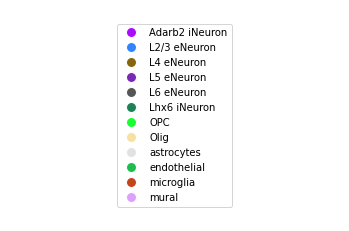

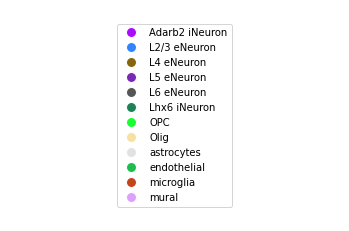

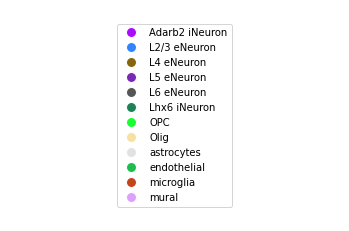

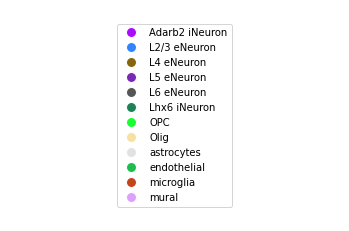

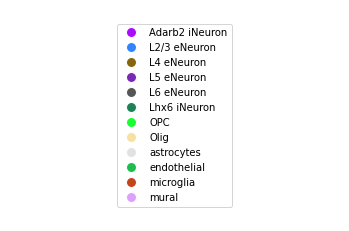

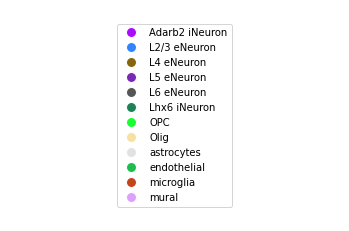

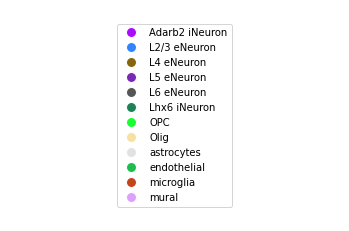

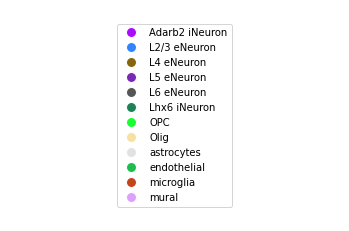

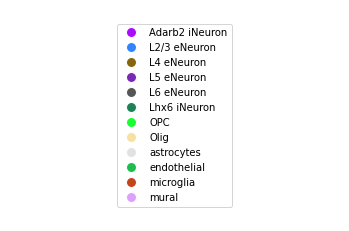

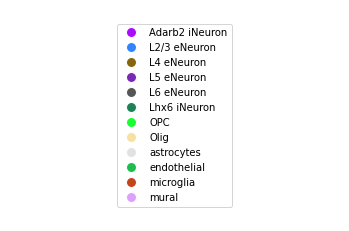

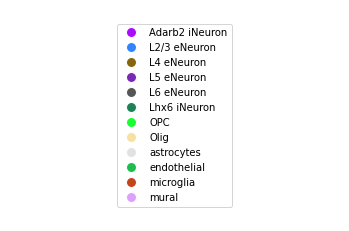

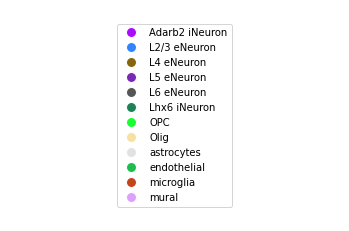

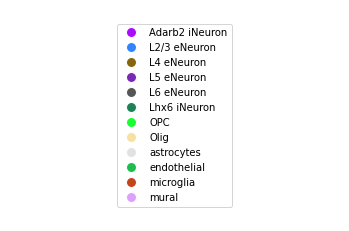

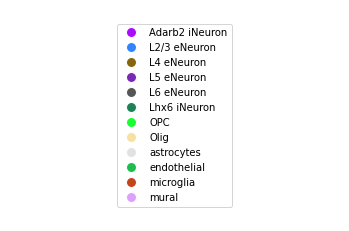

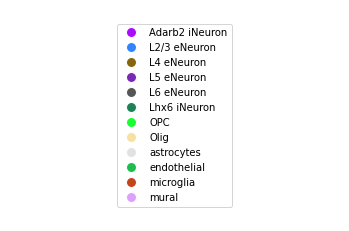

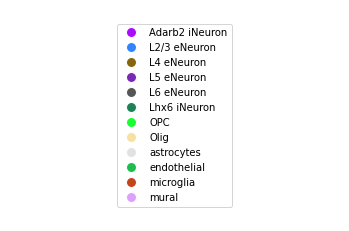

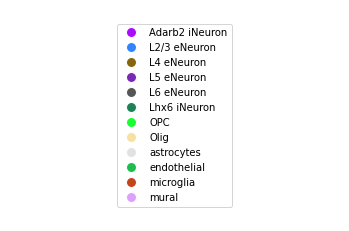

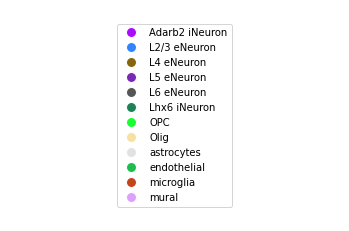

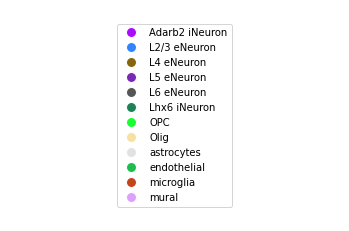

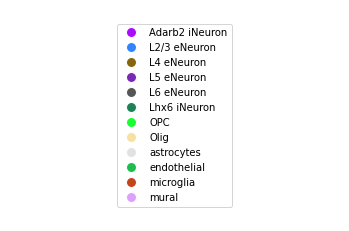

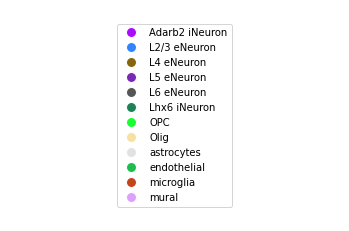

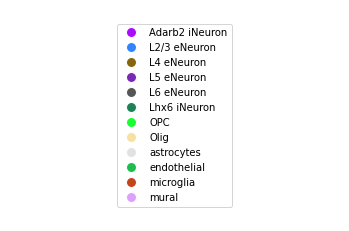

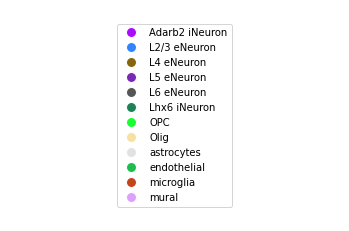

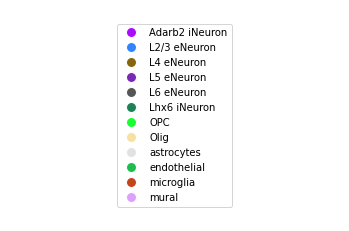

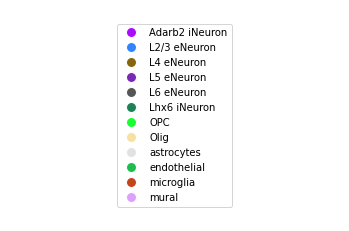

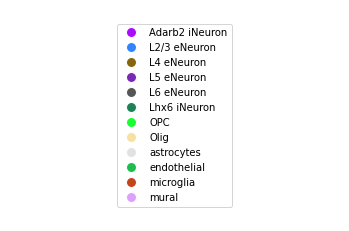

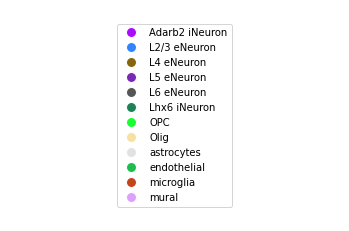

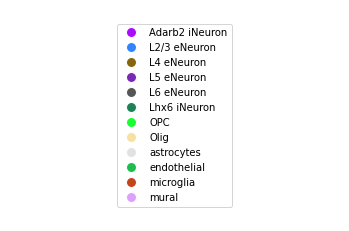

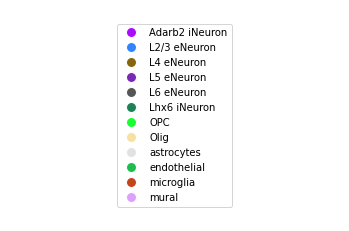

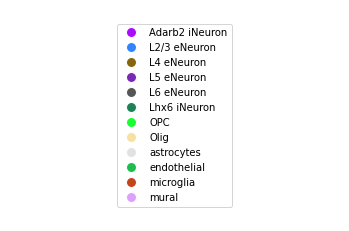

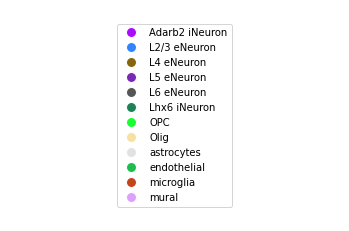

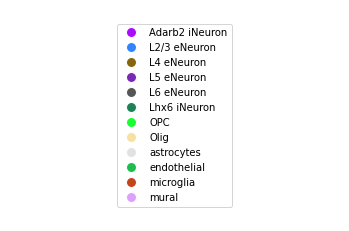

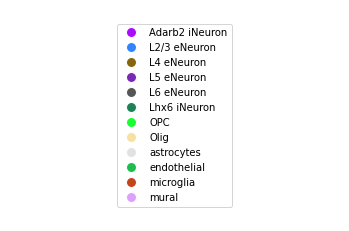

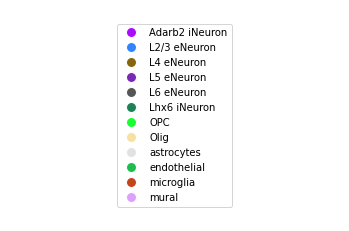

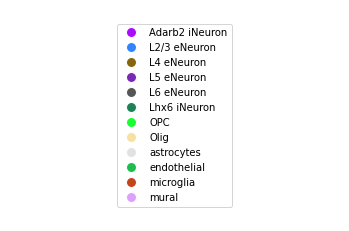

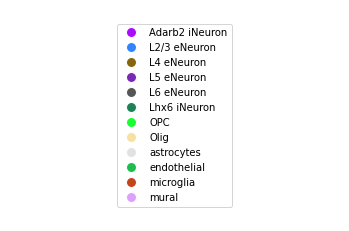

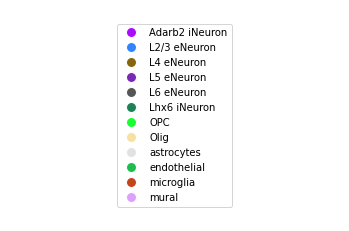

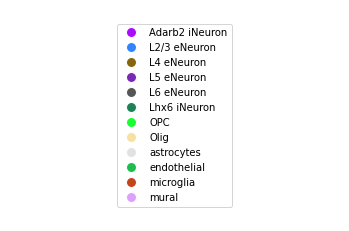

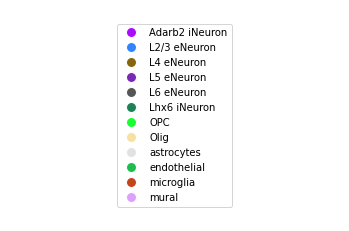

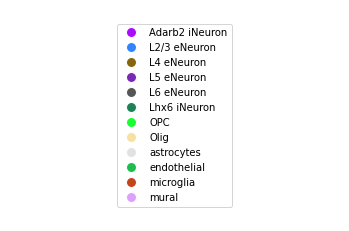

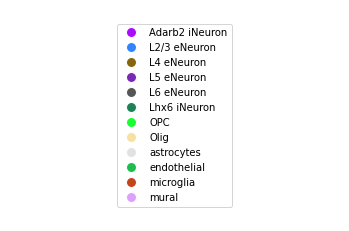

In [17]:
for pathway in pathways:
    ct.tl.cluster_communication(adata, database_name='cellchat', pathway_name=pathway, clustering='celltype', n_permutations=200)
    ct.pl.plot_cluster_communication_network(adata, uns_names=['commot_cluster-celltype-cellchat-%s' % pathway], clustering='celltype', p_value_cutoff=0.05, 
        nx_node_cmap='Alphabet', nx_node_pos='cluster', nx_bg_pos=True, filename='ccc_cluster-%s.pdf' % pathway, nx_bg_ndsize=0.25)

In [18]:
for lr_pair in lr_pairs:
    lig, rec = lr_pair.split('-')
    ct.tl.cluster_communication(adata, database_name='cellchat', lr_pair=[lig,rec], clustering='celltype')

In [19]:
adata.write("./data/adata.h5ad")

In [20]:
adata

AnnData object with n_obs × n_vars = 523 × 10000
    obs: 'celltype'
    uns: 'celltype_colors', 'commot-cellchat-info', 'cluster_pos-celltype', 'commot_cluster-celltype-cellchat-WNT', 'commot_cluster-celltype-cellchat-FGF', 'commot_cluster-celltype-cellchat-ncWNT', 'commot_cluster-celltype-cellchat-BMP', 'commot_cluster-celltype-cellchat-SEMA3', 'commot_cluster-celltype-cellchat-NRG', 'commot_cluster-celltype-cellchat-EGF', 'commot_cluster-celltype-cellchat-GAS', 'commot_cluster-celltype-cellchat-ANGPTL', 'commot_cluster-celltype-cellchat-ACTIVIN', 'commot_cluster-celltype-cellchat-VEGF', 'commot_cluster-celltype-cellchat-IGF', 'commot_cluster-celltype-cellchat-EDN', 'commot_cluster-celltype-cellchat-CCL', 'commot_cluster-celltype-cellchat-OPIOID', 'commot_cluster-celltype-cellchat-GDF', 'commot_cluster-celltype-cellchat-AGT', 'commot_cluster-celltype-cellchat-TGFb', 'commot_cluster-celltype-cellchat-ANGPT', 'commot_cluster-celltype-cellchat-PROS', 'commot_cluster-celltype-cellchat-PD

## **Cluster-cluster communication network (spatial permutation)**

In [8]:
adata = sc.read_h5ad("./data/adata.h5ad")
adata_spatial_permutation_allcells = adata_sp.copy()
adata_spatial_permutation_withincluster = adata_sp.copy()

In [9]:
%%timeit -n1 -r1
ct.tl.cluster_communication_spatial_permutation(adata_spatial_permutation_withincluster, database_name='cellchat', clustering='celltype',
    n_permutations=100, dis_thr=500, heteromeric=True, df_ligrec = adata.uns['commot-cellchat-info']['df_ligrec'], cot_nitermax=100,
    perm_type='within_cluster')

(598, 3)
(598, 3)
Permutation:  0
Permutation:  1
Permutation:  2
Permutation:  3
Permutation:  4
Permutation:  5
Permutation:  6
Permutation:  7
Permutation:  8
Permutation:  9
Permutation:  10
Permutation:  11
Permutation:  12
Permutation:  13
Permutation:  14
Permutation:  15
Permutation:  16
Permutation:  17
Permutation:  18
Permutation:  19
Permutation:  20
Permutation:  21
Permutation:  22
Permutation:  23
Permutation:  24
Permutation:  25
Permutation:  26
Permutation:  27
Permutation:  28
Permutation:  29
Permutation:  30
Permutation:  31
Permutation:  32
Permutation:  33
Permutation:  34
Permutation:  35
Permutation:  36
Permutation:  37
Permutation:  38
Permutation:  39
Permutation:  40
Permutation:  41
Permutation:  42
Permutation:  43
Permutation:  44
Permutation:  45
Permutation:  46
Permutation:  47
Permutation:  48
Permutation:  49
Permutation:  50
Permutation:  51
Permutation:  52
Permutation:  53
Permutation:  54
Permutation:  55
Permutation:  56
Permutation:  57
Permut

In [10]:
%%timeit -n1 -r1
ct.tl.cluster_communication_spatial_permutation(adata_spatial_permutation_allcells, database_name='cellchat', clustering='celltype',
    n_permutations=100, dis_thr=500, heteromeric=True, df_ligrec = adata.uns['commot-cellchat-info']['df_ligrec'], cot_nitermax=100,
    perm_type='all_cell')

(598, 3)
(598, 3)
Permutation:  0
Permutation:  1
Permutation:  2
Permutation:  3
Permutation:  4
Permutation:  5
Permutation:  6
Permutation:  7
Permutation:  8
Permutation:  9
Permutation:  10
Permutation:  11
Permutation:  12
Permutation:  13
Permutation:  14
Permutation:  15
Permutation:  16
Permutation:  17
Permutation:  18
Permutation:  19
Permutation:  20
Permutation:  21
Permutation:  22
Permutation:  23
Permutation:  24
Permutation:  25
Permutation:  26
Permutation:  27
Permutation:  28
Permutation:  29
Permutation:  30
Permutation:  31
Permutation:  32
Permutation:  33
Permutation:  34
Permutation:  35
Permutation:  36
Permutation:  37
Permutation:  38
Permutation:  39
Permutation:  40
Permutation:  41
Permutation:  42
Permutation:  43
Permutation:  44
Permutation:  45
Permutation:  46
Permutation:  47
Permutation:  48
Permutation:  49
Permutation:  50
Permutation:  51
Permutation:  52
Permutation:  53
Permutation:  54
Permutation:  55
Permutation:  56
Permutation:  57
Permut

In [11]:
adata_spatial_permutation_allcells.write("./data/adata_spatial_permutation_allcells.h5ad")
adata_spatial_permutation_withincluster.write("./data/adata_spatial_permutation_withincluster.h5ad")